In [1]:
import pandas as pd # datasets
import numpy as np # linear algebra
import cv2 # Images
import matplotlib.pyplot as plt # plotting
from tqdm import tqdm # progressbar
tqdm.pandas() # make progress bar work with pandas
import seaborn as sns # confsion matrix visualization
import os
# networks
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as tF
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
# helper functions
from sklearn.metrics import confusion_matrix, accuracy_score

num_classes=8
USE_GPU=True
batch = 250

In [2]:
toLabel = {0:'01_TUMOR', 1:'02_STROMA', 2:'03_COMPLEX', 3:'04_LYMPHO',\
         4:'05_DEBRIS', 5:'06_MUCOSA', 6:'07_ADIPOSE', 7:'08_EMPTY'}

toNum = {'01_TUMOR': 0,'02_STROMA': 1,'03_COMPLEX': 2,'04_LYMPHO': 3,\
         '05_DEBRIS': 4,'06_MUCOSA': 5,'07_ADIPOSE': 6,'08_EMPTY': 7}


train_transform = transforms.Compose([            
    transforms.ToTensor(),
    transforms.RandomAffine(90, translate=(0.15,0.15), scale=(0.75,1.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((150,150)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150,150)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
def read(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

class ImageDataset(Dataset):
    
    def __init__(self,data,transform=None):
        self.data=data
        self.transform=transform
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img = self.data['tensor'].values[idx]
        if self.transform is not None:
            img = self.transform(img)
           
        labels = torch.tensor(self.data['target'].values[idx])
        return img, labels

In [4]:
df = pd.read_csv('train.csv')
df['target'] = df['category'].map(toNum)
df['tensor'] = df['path'].progress_map(read)

100%|██████████| 5000/5000 [00:00<00:00, 5562.93it/s]


In [5]:
train_df = df[df['train']]
val_df = df[df['train'] == 0]

In [6]:
train_loader = DataLoader(ImageDataset(train_df, transform = train_transform),batch_size=batch,shuffle=True)
val_loader = DataLoader(ImageDataset(val_df, transform = test_transform),batch_size=batch,shuffle=True)

In [7]:
import torchvision.models as models

class Net(nn.Module):
    def __init__(self, criterion=None):
        super(Net, self).__init__()
        self.criterion = criterion
        self.rn = models.densenet121(pretrained=True)
        self.rn.classifier = nn.Linear(1024, num_classes)
    def forward(self, inp, gts=None):
        inp = self.rn(inp)
        lfinal = F.log_softmax(inp, dim=1)
        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)      
        else:
            # Return the actual prediction otherwise
            return torch.exp(lfinal)

In [8]:
# Validation Loop

def val_epoch(loader, model, vis=True, loss=False):    
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, target = data
            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()
                model = model.cuda()

            output = model(inputs)
            preds.extend(output.argmax(dim=1, keepdim=True).detach().cpu().numpy().flatten())
            targets.extend(target.cpu().numpy())
    cm = confusion_matrix(targets,preds)
    acc = accuracy_score(targets,preds)
    if vis:
        labels = list(toNum.keys())
        sns.heatmap(cm,annot=True,cbar=False,cmap='Blues',xticklabels=labels, yticklabels=labels)
        plt.xticks(rotation=45)
    return acc

In [9]:
def get_optimizer(model):
    optimizer = optim.Adamax(model.parameters())
    scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.3)
    return optimizer, scheduler

In [10]:
# Training Loop

def train_epoch(train_loader, model, optimizer, loss_graph):
    model.train()
    t = tqdm(enumerate(train_loader),total=len(train_loader))
    for i, data in t:
        
        inputs, target = data
        if USE_GPU:
            inputs = inputs.cuda()
            model = model.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        main_loss = model(inputs, gts=target)
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()
        t.set_description(f"Loss: {main_loss.item():.3f}")
        t.refresh() # to show immediately the update
    return main_loss

In [11]:
def train(loader, model, epochs, acc=False, val=None):
    '''
    training loop
    
    loader: DataLoader
    model: model to train
    epochs: number of epochs to train on
    acc: if accuracy is to be computed at the end of each epoch, if val = None it only computes train accuracy
    val: validation set to compute the validation accuracy
    '''
    optimizer,sch = get_optimizer(model)
    print("Starting Training...")

    loss_graph = []
    val_idx = [0]
    best_acc = 0
    fig = plt.figure(figsize=(30,12))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax1 = fig.add_subplot(1,1,1)
    if acc:
        if val!=None:
            val_graph = []
            val_acc = val_epoch(val, model, vis=False)
            val_graph.append(val_acc)
        tr_graph = []
        tr_acc = val_epoch(loader, model, vis=False)
        tr_graph.append(tr_acc)
        ax2 = ax1.twinx()
    for e in range(epochs):
        loss = train_epoch(loader, model, optimizer, loss_graph)
        val_idx.append((e + 1) * len(loader))
        
        ax1.clear()
        ax1.set_xlabel('iterations')
        ax1.set_ylabel('loss value')
        ax1.set_title('Training loss curve')
        ax1.plot(loss_graph, label='training loss')
        ax1.legend(loc='upper left')
        if acc:
            if val!=None:
                val_acc = val_epoch(val, model, vis=False)
                val_graph.append(val_acc)
                if val_acc > best_acc:
                    torch.save(model, "best.pth")
                    best_acc = val_acc
            tr_acc = val_epoch(loader, model, vis=False)
            tr_graph.append(tr_acc)
            ax2.clear()
            ax2.set_ylabel('accuracy')
            if val != None:
                ax2.plot(val_idx, val_graph, label='validation accuracy', color='tab:red')
            ax2.plot(val_idx, tr_graph, label='training accuracy', color='tab:purple')
            ax2.legend(loc='lower left')
        fig.canvas.draw()
        print(f"\nEpoch: {e} Loss: {loss} Vallidation Accuracy: {val_acc}")
        sch.step()
    torch.save(model,"model.pth")

In [12]:
# Create networks
model = Net(criterion=F.nll_loss)

Starting Training...


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 0 Loss: 0.36101052165031433 Vallidation Accuracy: 0.772


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 1 Loss: 0.27063077688217163 Vallidation Accuracy: 0.93


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 2 Loss: 0.21141834557056427 Vallidation Accuracy: 0.94


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 3 Loss: 0.18825697898864746 Vallidation Accuracy: 0.916


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 4 Loss: 0.1904863864183426 Vallidation Accuracy: 0.934


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 5 Loss: 0.10524927824735641 Vallidation Accuracy: 0.97


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 6 Loss: 0.09673117846250534 Vallidation Accuracy: 0.974


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 7 Loss: 0.19408461451530457 Vallidation Accuracy: 0.976


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 8 Loss: 0.12295778840780258 Vallidation Accuracy: 0.964


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 9 Loss: 0.1077423021197319 Vallidation Accuracy: 0.974


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 10 Loss: 0.0831979513168335 Vallidation Accuracy: 0.972


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 11 Loss: 0.06307138502597809 Vallidation Accuracy: 0.978


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 12 Loss: 0.11474958062171936 Vallidation Accuracy: 0.974


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 13 Loss: 0.11790556460618973 Vallidation Accuracy: 0.98


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 14 Loss: 0.12585540115833282 Vallidation Accuracy: 0.97


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 15 Loss: 0.15572994947433472 Vallidation Accuracy: 0.976


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 16 Loss: 0.08908186107873917 Vallidation Accuracy: 0.974


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 17 Loss: 0.07437935471534729 Vallidation Accuracy: 0.974


  0%|          | 0/18 [00:00<?, ?it/s]


Epoch: 18 Loss: 0.12053292244672775 Vallidation Accuracy: 0.978


Loss: 0.141: 100%|██████████| 18/18 [00:43<00:00,  2.41s/it]



Epoch: 19 Loss: 0.1413143277168274 Vallidation Accuracy: 0.972


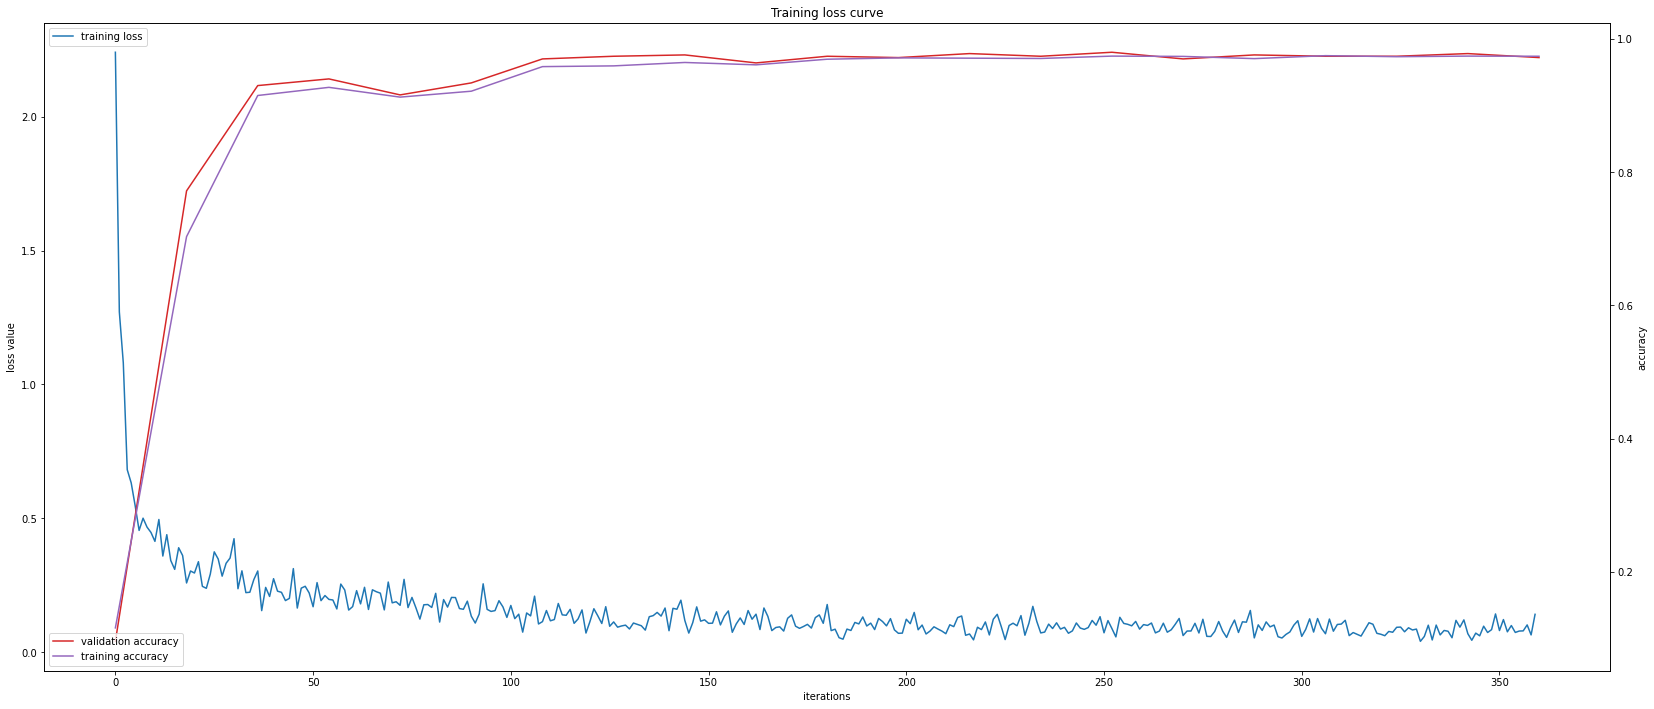

In [13]:
train(train_loader, model, 20, acc=True, val=val_loader)

0.972

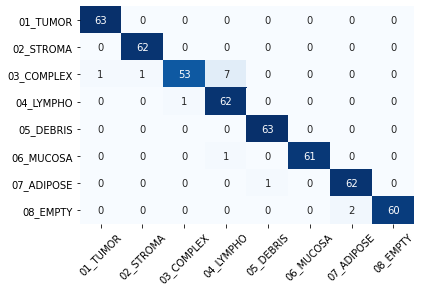

In [14]:
val_epoch(val_loader,model)

0.98

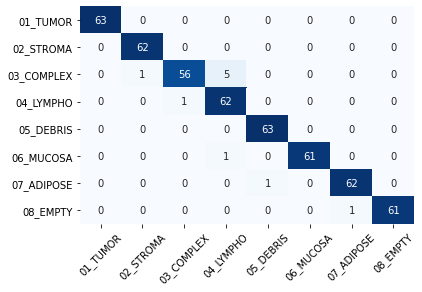

In [15]:
best = torch.load('best.pth')
val_epoch(val_loader,best)

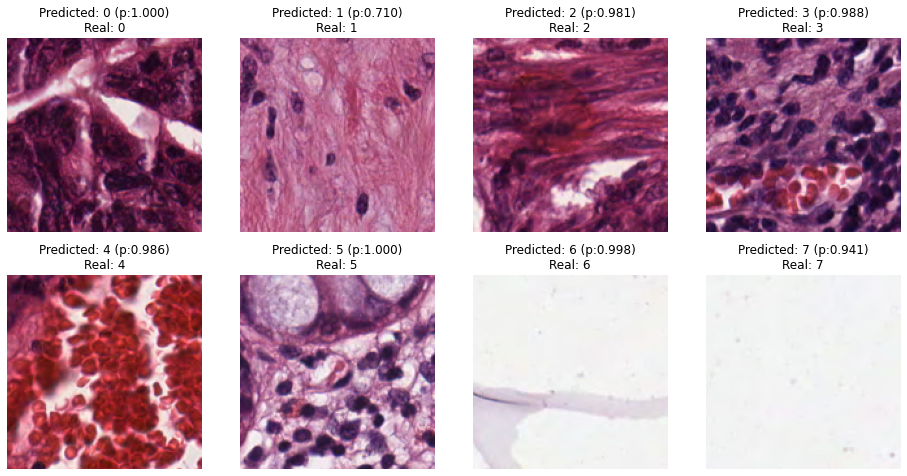

In [16]:
examples = pd.concat([val_df[val_df['target']==i].sample(1) for i in range(8)])
images = examples['tensor']
targets = examples['target']
x = torch.stack([test_transform(i) for i in images]).cuda()
preds = best(x).detach().cpu().numpy()

fig, axs = plt.subplots(2,4,figsize=(16,8))
for image,pred,target,ax in zip(images,preds,targets,axs.flatten()):
    ax.imshow(image)
    ax.set_title(f'Predicted: {pred.argmax()} (p:{pred[pred.argmax()]:.3f})\nReal: {target}')
    ax.axis('off')